Let's try post-process to reduce the fragmentation we have in the optimal model. This way of improving was dicided after the progress report.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Read data and predicted labels
We use the optimal model, SVC on rolling data.

In [2]:
y_df = pd.read_csv('results/roll_dev_y.csv', index_col=0)
y_df.head()

,y,y_lr,y_svc,y_rf,core_section
0,0,1,1,1,N11-2
1,0,1,1,1,N11-2
2,0,1,1,1,N11-2
3,0,1,1,1,N11-2
4,0,1,1,1,N11-2


# Functions for smoothing and evaluation

In [5]:
def smooth(y, groups, window):
    """
    This function smoothes the labels in each core section.
    y is the label array.
    groups is the core section list.
    window is the window size each time the function looking at.
    """
    y_s = []
    for core_section in np.unique(groups):
        y_g = y[groups == core_section]
        i = 0

        # the last elements not enough for a window size will be excluded 
        while (i + window) < len(y_g):
            value, count = np.unique(y_g[i: i+window], return_counts=True)
            # set the dominant value in the window as the values
            y_s = np.hstack((y_s, np.repeat(value[np.argmax(count)], window)))
            i += window
        # add the last part of data that can't be smoothed to the new array
        y_s = np.hstack((y_s, y_g[i:]))
    return y_s.astype(int)

In [4]:
def count_boundary(y, groups):
    """
    y is the label to count boundary within each section.
    groups is the core section.
    """
    bd = []
    for section in np.unique(groups):
        y_g = y[groups == section]
        for i in range(len(y_g) - 1):
            if y_g[i] != y_g[i+1]:
                bd.append(True)
            else:
                bd.append(False)
    return np.sum(bd)

In [5]:
count_boundary(y_df.y.values, y_df.core_section.values)

22

The boundary amount of human description is consistent to the way we did for illustrating conjunctions.

# Execute

In [8]:
%%time
from sklearn.metrics import balanced_accuracy_score as score
windows = []
scores = []
bds = []

for window in range(5, 200):
    windows.append(window)
    y_s = smooth(y_df.y_svc.values, y_df.core_section.values, window)
    scores.append(score(y_true=y_df.y, y_pred=y_s))
    bds.append(count_boundary(y_s, y_df.core_section.values))

windows = np.array(windows)
scores = np.array(scores)
bds = np.array(bds)

CPU times: user 23.5 s, sys: 0 ns, total: 23.5 s
Wall time: 23.7 s


In [19]:
plt.style.use('default')
plt.style.use('seaborn-colorblind')

20210618


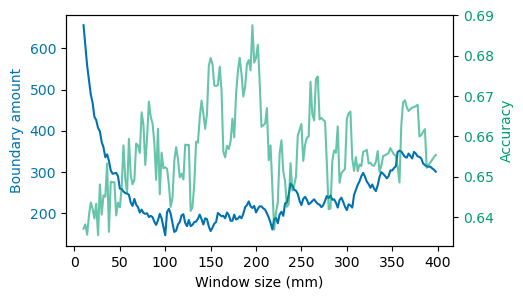

In [25]:
fig, ax1 = plt.subplots(figsize=(5, 3))
ax1.set_xlabel('Window size (mm)')
ax1.set_ylabel('Boundary amount', c='C0')
ax1.plot(windows*2, bds, c='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', c='C1')
ax2.plot(windows*2, scores, c='C1', alpha=.6)
ax2.tick_params(axis='y', labelcolor='C1')

#fig.tight_layout() 
fig.savefig('results/roll_dev_post_evaluation_{}.png'.format(date))
print(date)

In [27]:
pd.DataFrame(dict(
    window_size_mm=windows*2,
    boundary=bds,
    balanced_score=scores
)).to_csv('results/roll_dev_post_evaluation_{}.csv'.format(date))
print(date)

20210618


# Summary
The post-processing's result looks satisfacory. Both boundary amount and accuracy at the window size range have converging behavior. The boundary amount reduced significantly to around 200, which fit our goal of reducing fragmentation (i.e. 10 times of the human description). Although the accuracy isn't notably increased, it's still an improvement. The trend shows the converging part falls between 134-212 mm window size. I choose 150 mm (75 data points) as the window size since it has the fewest boundary amount and reasonably high accuracy. I focus on the boundary amount a bit more than accuracy because it has more notable improvement differences and it's our main target for this try.

The limited improvement of accuracy, while the fragmentation is siginificantly suppressed, shows there is still other mainly contributing error category, human bias. The sedimentologists have their own bias when comparing to each other, which may be quantitatively described by the difference after Dirk's reclassification. Besides, they use coring locations as their initial knowledge of classification (also including interpretation), which we excluded intentionaly in our data to make the machine "objective". Nevertheless, the post-process of "looking wider" is still different from "looking wider during classification", so it may not fully solved the error caused by looking too narrowlly (i.e. the error category, "XRF can’t or incorrectly depict the composite characteristic as human does, causing the misclassification of fragmented facies" may not be fully eliminated).

Later on I'll write a script to integrate the SVC-roll model and this post-process as our machine. And use it on our test set to write final discussion. But, be cautious, the test set is for describing machine's property, not for optimization.

# Evaluation of the processed predictions

In [6]:
y_df['y_svc_s'] = smooth(y_df.y_svc.values, y_df.core_section.values, 75)

In [9]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [7]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/roll_{}_recall_%_{}_{}.png'.format(split, model_name, date))

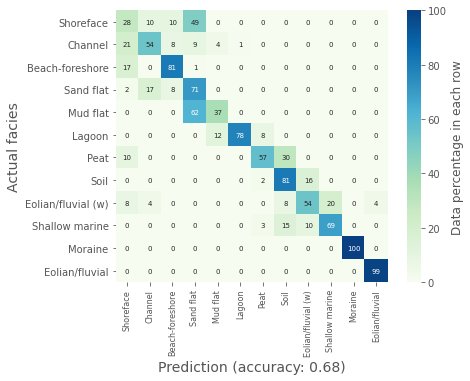

In [10]:
plot_recall(y_df, ['y_svc_s'], Facies, 'dev')

In [11]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 6:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 22 boundaries in description.
There are 157 boundaries in the optimized svc_s model's predictions.


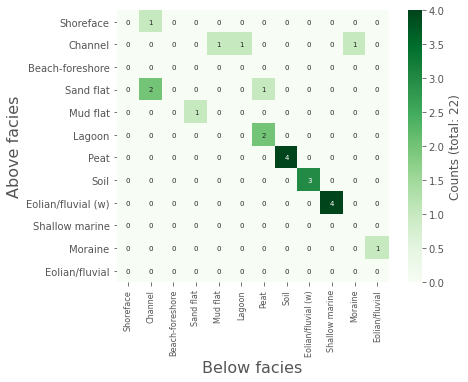

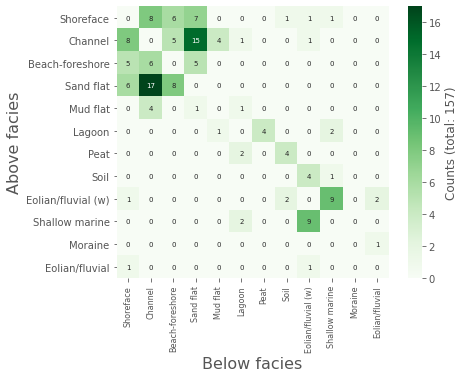

In [12]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_svc_s'], Facies, 'dev')